## Analysis of Convolving tensors using fast fourier transform

In [1]:
from functools import partial
from typing import Iterable, Tuple, Union

import torch
from torch import nn
import torch.nn.functional as f
from torch import Tensor, nn
from torch.fft import irfftn, rfftn

from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)

### Implementation of FFT Convolutional Layer

In [ ]:
def complex_matmul(a: Tensor, b: Tensor, groups: int = 1) -> Tensor:
    """Multiplies two complex-valued tensors."""
    # Scalar matrix multiplication of two tensors, over only the first channel
    # dimensions. Dimensions 3 and higher will have the same shape after multiplication.
    # We also allow for "grouped" multiplications, where multiple sections of channels
    # are multiplied independently of one another (required for group convolutions).
    scalar_matmul = partial(torch.einsum, "agc..., gbc... -> agb...")
    a = a.view(a.size(0), groups, -1, *a.shape[2:])
    b = b.view(groups, -1, *b.shape[1:])

    # Compute the real and imaginary parts independently, then manually insert them
    # into the output Tensor.  This is fairly hacky but necessary for PyTorch 1.7.0,
    # because Autograd is not enabled for complex matrix operations yet.  Not exactly
    # idiomatic PyTorch code, but it should work for all future versions (>= 1.7.0).
    real = scalar_matmul(a.real, b.real) - scalar_matmul(a.imag, b.imag)
    imag = scalar_matmul(a.imag, b.real) + scalar_matmul(a.real, b.imag)
    c = torch.zeros(real.shape, dtype=torch.complex64, device=a.device)
    c.real, c.imag = real, imag

    return c.view(c.size(0), -1, *c.shape[3:])


def to_ntuple(val: Union[int, Iterable[int]], n: int) -> Tuple[int, ...]:
    """Casts to a tuple with length 'n'.  Useful for automatically computing the
    padding and stride for convolutions, where users may only provide an integer.
    Args:
        val: (Union[int, Iterable[int]]) Value to cast into a tuple.
        n: (int) Desired length of the tuple
    Returns:
        (Tuple[int, ...]) Tuple of length 'n'
    """
    if isinstance(val, Iterable):
        out = tuple(val)
        if len(out) == n:
            return out
        else:
            raise ValueError(f"Cannot cast tuple of length {len(out)} to length {n}.")
    else:
        return n * (val,)


def fft_conv(
    signal: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding: Union[int, Iterable[int]] = 0,
    stride: Union[int, Iterable[int]] = 1,
    groups: int = 1,
) -> Tensor:
    """Performs N-d convolution of Tensors using a fast fourier transform, which
    is very fast for large kernel sizes. Also, optionally adds a bias Tensor after
    the convolution (in order ot mimic the PyTorch direct convolution).
    Args:
        signal: (Tensor) Input tensor to be convolved with the kernel.
        kernel: (Tensor) Convolution kernel.
        bias: (Tensor) Bias tensor to add to the output.
        padding: (Union[int, Iterable[int]) Number of zero samples to pad the
            input on the last dimension.
        stride: (Union[int, Iterable[int]) Stride size for computing output values.
    Returns:
        (Tensor) Convolved tensor
    """
    # Cast padding & stride to tuples.
    padding_ = to_ntuple(padding, n=signal.ndim - 2)
    stride_ = to_ntuple(stride, n=signal.ndim - 2)

    # Pad the input signal & kernel tensors
    signal_padding = [p for p in padding_[::-1] for _ in range(2)]
    signal = f.pad(signal, signal_padding)

    # Because PyTorch computes a *one-sided* FFT, we need the final dimension to
    # have *even* length.  Just pad with one more zero if the final dimension is odd.
    if signal.size(-1) % 2 != 0:
        signal_ = f.pad(signal, [0, 1])
    else:
        signal_ = signal

    kernel_padding = [
        pad
        for i in reversed(range(2, signal_.ndim))
        for pad in [0, signal_.size(i) - kernel.size(i)]
    ]
    padded_kernel = f.pad(kernel, kernel_padding)

    # Perform fourier convolution -- FFT, matrix multiply, then IFFT
    # signal_ = signal_.reshape(signal_.size(0), groups, -1, *signal_.shape[2:])
    signal_fr = rfftn(signal_, dim=tuple(range(2, signal.ndim)))
    kernel_fr = rfftn(padded_kernel, dim=tuple(range(2, signal.ndim)))

    kernel_fr.imag *= -1
    output_fr = complex_matmul(signal_fr, kernel_fr, groups=groups)
    output = irfftn(output_fr, dim=tuple(range(2, signal.ndim)))

    # Remove extra padded values
    crop_slices = [slice(0, output.size(0)), slice(0, output.size(1))] + [
        slice(0, (signal.size(i) - kernel.size(i) + 1), stride_[i - 2])
        for i in range(2, signal.ndim)
    ]
    output = output[crop_slices].contiguous()

    # Optionally, add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (signal.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output


class _FFTConv(nn.Module):
    """Base class for PyTorch FFT convolution layers."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding: Union[int, Iterable[int]] = 0,
        stride: Union[int, Iterable[int]] = 1,
        groups: int = 1,
        bias: bool = True,
        ndim: int = 1,
    ):
        """
        Args:
            in_channels: (int) Number of channels in input tensors
            out_channels: (int) Number of channels in output tensors
            kernel_size: (Union[int, Iterable[int]) Square radius of the kernel
            padding: (Union[int, Iterable[int]) Number of zero samples to pad the
                input on the last dimension.
            stride: (Union[int, Iterable[int]) Stride size for computing output values.
            bias: (bool) If True, includes bias, which is added after convolution
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.groups = groups
        self.use_bias = bias

        if in_channels % groups != 0:
            raise ValueError(
                "'in_channels' must be divisible by 'groups'."
                f"Found: in_channels={in_channels}, groups={groups}."
            )
        if out_channels % groups != 0:
            raise ValueError(
                "'out_channels' must be divisible by 'groups'."
                f"Found: out_channels={out_channels}, groups={groups}."
            )

        kernel_size = to_ntuple(kernel_size, ndim)
        self.weight = nn.Parameter(
            torch.randn(out_channels, in_channels // groups, *kernel_size)
        )
        self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

    def forward(self, signal):
        return fft_conv(
            signal,
            self.weight,
            bias=self.bias,
            padding=self.padding,
            stride=self.stride,
            groups=self.groups,
        )


FFTConv1d = partial(_FFTConv, ndim=1)
FFTConv2d = partial(_FFTConv, ndim=2)
FFTConv3d = partial(_FFTConv, ndim=3)

#### Implementation of Custom 1D, 2D, 3D Convolutional Layers

In [ ]:
def conv_1d(kernel, bias, x):
    kernel_shape = kernel.shape[0]
    output_shape = x.shape[0] - kernel_shape + 1
    result = np.zeros(output_shape)
    for index in range(x.shape[0] - (kernel_shape - 1)):
        window = x[index: index + kernel_shape]
        result[index] = np.sum(np.multiply(kernel, window))
    return result + bias

def conv_2d(kernel, bias, x):
    kernel_shape = kernel.shape[0]
    output_shape = x.shape[0] - kernel_shape + 1
    result = np.zeros((output_shape, output_shape))
    for row in range(x.shape[0] - (kernel_shape - 1)):
        for col in range(x.shape[1] - (kernel_shape - 1)):
            window = x[row: row + kernel_shape, col: col + kernel_shape]
            result[row, col] = np.sum(np.multiply(kernel, window))
    return result + bias

def conv_3d(kernel, bias, x):
    kernel_shape = kernel.shape[0]
    output_shape = x.shape[0] - kernel_shape + 1
    result = np.zeros((output_shape, output_shape, output_shape))
    for index1 in range(x.shape[0] - (kernel_shape - 1)):
        for index2 in range(x.shape[1] - (kernel_shape - 1)):
          for index3 in range(x.shape[2] - (kernel_shape - 1)):
            window = x[index1: index1 + kernel_shape, index2: index2 + kernel_shape, index3: index3 + kernel_shape]
            result[index1, index2, index3] = np.sum(np.multiply(kernel, window))
    return result + bias

#### Input Size vs Execution Time

- In this experiment, we run an analysis against input sizes and execution times of the custom convolution algorithm against the Fast fourier transform version of the convolution.

Parameters:

- Input size: 3-300 in steps of 5
- Kernel Size: 2
- Dimension: 2 (Conv2D)
- Total Runs: 20

100%|██████████| 60/60 [04:05<00:00,  4.09s/it]


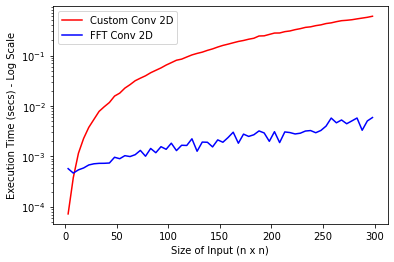

In [ ]:
naive_time_log = []
fft_time_log = []

MAX_INPUT_SIZE = 300
NUM_RUNS = 20
input_size_list = list(range(3, MAX_INPUT_SIZE, 5))

for input_size in tqdm(input_size_list):
    naive_time = np.zeros(NUM_RUNS)
    fft_time = np.zeros(NUM_RUNS)
    for run in range(NUM_RUNS):
        conv = nn.Conv2d(1, 1, 2)
        fft_conv_layer = FFTConv2d(1,1,2)

        ip = torch.randint(low=0, high=10, size=(1, 1, input_size, input_size),  dtype=torch.float32)

        conv.weight = nn.Parameter(torch.randint(low=0, high=10, size=(1, 1, 2, 2),  dtype=torch.float32))
        fft_conv_layer.weight = conv.weight

        ip_np = ip.numpy().reshape(-1, ip.shape[-1])
        kernel_np = conv.weight.detach().squeeze().numpy()
        bias_np = conv.bias.detach().squeeze().numpy()
        start = time()
        naive_conv = conv_2d(kernel_np, bias_np, ip_np)
        naive_time[run] = time() - start

        start = time()
        fft_conv_out = fft_conv_layer(ip)
        fft_time[run] = time() - start
        
    naive_time_log.append(naive_time.mean())
    fft_time_log.append(fft_time.mean())

plt.plot(input_size_list, naive_time_log,
         label='Custom Conv 2D', color='red')
plt.plot(input_size_list, fft_time_log,
         label='FFT Conv 2D', color='blue')

plt.xlabel('Size of Input (n x n)')
plt.ylabel('Execution Time (secs) - Log Scale')
plt.yscale("log")
plt.legend()
plt.show()

#### Kernel Size vs Execution Time

- In this experiment, we run an analysis against kernel size and execution times for the 2 algorithms

Parameters:

- Input size: 150
- Kernel Size: 2-50 in steps of 2
- Dimension: 2 (Conv2D)
- Total Runs: 20

100%|██████████| 24/24 [00:59<00:00,  2.46s/it]


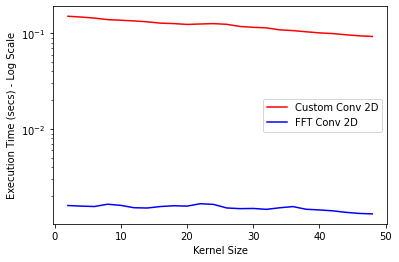

In [ ]:
naive_time_log = []
fft_time_log = []

MAX_KERNEL_SIZE = 50
NUM_RUNS = 20
kernel_sizes = list(range(2, MAX_KERNEL_SIZE, 2))

for kernel_size in tqdm(kernel_sizes):
    naive_time = np.zeros(NUM_RUNS)
    fft_time = np.zeros(NUM_RUNS)
    for run in range(NUM_RUNS):
        conv = nn.Conv2d(1, 1, kernel_size)
        fft_conv_layer = FFTConv2d(1,1,kernel_size)

        ip = torch.randint(low=0, high=10, size=(1, 1, 150, 150),  dtype=torch.float32)

        conv.weight = nn.Parameter(torch.randint(low=0, high=10, size=(1, 1, kernel_size, kernel_size),  dtype=torch.float32))
        fft_conv_layer.weight = conv.weight

        ip_np = ip.numpy().reshape(-1, ip.shape[-1])
        kernel_np = conv.weight.detach().squeeze().numpy()
        bias_np = conv.bias.detach().squeeze().numpy()
        start = time()
        naive_conv = conv_2d(kernel_np, bias_np, ip_np)
        naive_time[run] = time() - start
        start = time()
        fft_conv_out = fft_conv_layer(ip)
        fft_time[run] = time() - start
        
    naive_time_log.append(naive_time.mean())
    fft_time_log.append(fft_time.mean())

plt.plot(kernel_sizes, naive_time_log,
         label='Custom Conv 2D', color='red')
plt.plot(kernel_sizes, fft_time_log,
         label='FFT Conv 2D', color='blue')

plt.xlabel('Kernel Size')
plt.ylabel('Execution Time (secs) - Log Scale')
plt.yscale("log")
plt.legend()
plt.show()

#### Dimension Size vs Execution Time

- In this experiment, we run an analysis against Dimension Size and execution times for the 2 algorithms

Parameters:

- Input size: 50
- Kernel Size: 2
- Dimension: 1 (Conv1D), 2 (Conv2D), 3 (Conv3D)
- Total Runs: 20

100%|██████████| 3/3 [00:17<00:00,  5.70s/it]


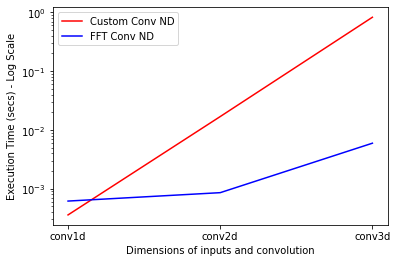

In [ ]:
naive_time_log = []
fft_time_log = []

NUM_RUNS = 20

conv_arr = ['conv1d', 'conv2d', 'conv3d']
fft_conv_fns = [FFTConv1d, FFTConv2d, FFTConv3d]
torch_conv_fns = [nn.Conv1d, nn.Conv2d, nn.Conv3d]
custom_conv_fns = [conv_1d, conv_2d, conv_3d]

for conv_i in tqdm(range(len(fft_conv_fns))):
    naive_time = np.zeros(NUM_RUNS)
    fft_time = np.zeros(NUM_RUNS)
    for run in range(NUM_RUNS):
        conv = torch_conv_fns[conv_i](1, 1, 2)
        fft_conv_layer = fft_conv_fns[conv_i](1,1,2)

        ip_arr = [50] * (conv_i + 1)
        ip = torch.randint(low=0, high=10, size=(1, 1, *ip_arr),  dtype=torch.float32)

        weight_arr = [2] * (conv_i + 1)
        conv.weight = nn.Parameter(torch.randint(low=0, high=10, size=(1, 1, *weight_arr),  dtype=torch.float32))
        fft_conv_layer.weight = conv.weight

        ip_np = ip.numpy().reshape(-1, *([50] * conv_i))
        kernel_np = conv.weight.detach().squeeze().numpy()
        bias_np = conv.bias.detach().squeeze().numpy()
        start = time()
        naive_conv = custom_conv_fns[conv_i](kernel_np, bias_np, ip_np)
        naive_time[run] = time() - start
        start = time()
        fft_conv_out = fft_conv_layer(ip)
        fft_time[run] = time() - start
        
    naive_time_log.append(naive_time.mean())
    fft_time_log.append(fft_time.mean())

plt.plot(conv_arr, naive_time_log,
         label='Custom Conv ND', color='red')
plt.plot(conv_arr, fft_time_log,
         label='FFT Conv ND', color='blue')

plt.xlabel('Dimensions of inputs and convolution')
plt.ylabel('Execution Time (secs) - Log Scale')
plt.yscale("log")
plt.legend()
plt.show()

#### **References:**

1. Fast Training of Convolutional Neural Networks through FFTs, https://arxiv.org/pdf/1312.5851.pdf

2. How Are Convolutions Actually Performed Under the Hood? https://towardsdatascience.com/how-are-convolutions-actually-performed-under-the-hood-226523ce7fbf

3. FFT - Convolution operations using pytorch, https://github.com/fkodom/fft-conv-pytorch
